In [ ]:
# Section 1: Setup & Imports
from google.colab import drive
drive.mount('/content/drive')

# If you prefer to import idlmam.py from your week6 folder, uncomment and adjust the next two lines:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/week6')

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Mounted at /content/drive


In [ ]:
# Section 2: Load MNIST (ToTensor only as per assignment)
transform = transforms.ToTensor()

mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test  = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

B = 32  # batch size used in assignment
train_loader = DataLoader(mnist_train, batch_size=B, shuffle=True, num_workers=2)
test_loader  = DataLoader(mnist_test,  batch_size=B, shuffle=False, num_workers=2)

print("Train samples:", len(mnist_train), " Test samples:", len(mnist_test))


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.30MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 121kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.26MB/s]

Train samples: 60000  Test samples: 10000


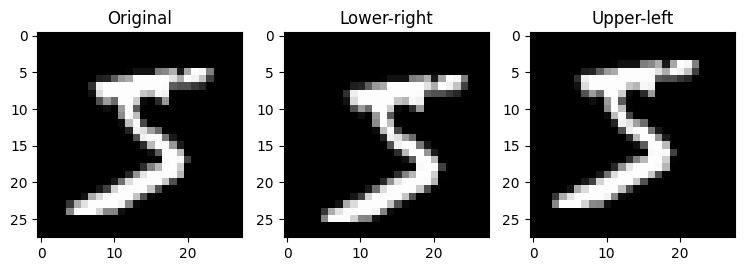

In [ ]:
# Section 3: Example image + shifted variants (used in Section A)
img_idx = 0
img_tensor, correct_class = mnist_train[img_idx]  # img_tensor shape = (1,28,28)
img = img_tensor[0].numpy()  # (28,28) numpy array for visualization & pred helper

# create shifted images (lower-right and upper-left by 1 pixel)
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0)   # lower-right
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0) # upper-left

# show them
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].imshow(img, cmap='gray'); ax[0].set_title('Original')
ax[1].imshow(img_lr, cmap='gray'); ax[1].set_title('Lower-right')
ax[2].imshow(img_ul, cmap='gray'); ax[2].set_title('Upper-left')
plt.show()


In [ ]:
# Section 4: Model definitions (match the official notebook)

D = 28 * 28
C = 1
filters = 16
classes = 10
K = 3

# Simple CNN (single conv -> tanh -> flatten -> linear) -- matches the "correct" example
model_simple = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(filters * D, classes)
)

# Deeper CNN with two rounds of pooling (exact architecture from correct version)
model_cnn_pool = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2),

    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(2*filters * D // (4**2), classes),
)

# quick sanity prints
print("Simple model:", model_simple)
print("Pool model:", model_cnn_pool)


Simple model: Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=12544, out_features=10, bias=True)
)
Pool model: Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Tanh()
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Tanh()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): Tanh()
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): Tanh()
  (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): Tanh()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=1568

In [ ]:
# Section 5: pred() helper (works with numpy or tensor images shaped (H,W))
def pred(model, img):
    model_cpu = model.cpu().eval()
    with torch.no_grad():
        # ensure numpy -> tensor
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img, dtype=torch.float32)
        # reshape into (B, C, W, H)
        w, h = img.shape
        x = img.reshape(1, -1, w, h)  # this follows the exercise shape convention
        logits = model_cpu(x)
        probs = F.softmax(logits, dim=1)
        return probs.numpy().flatten()


In [ ]:
# Section 6: train_simple_network (SGD, returns pandas DataFrame with epoch & test Accuracy)
def train_simple_network(model, loss_func, train_loader, test_loader, score_funcs,
                         device, epochs=20, lr=0.001):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    history = {"epoch": [], "test Accuracy": []}

    for epoch in tqdm(range(epochs), desc="Epoch"):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # evaluation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        acc = score_funcs["Accuracy"](all_labels, all_preds)
        history["epoch"].append(epoch + 1)
        history["test Accuracy"].append(acc)

    # convert to DataFrame for plotting convenience (like the correct notebook)
    return pd.DataFrame.from_dict(history)


In [ ]:
# Section 7: Section A - predictions on original / shifted images with a model from Week5
# Use model_simple (not trained) as the exercise suggests using the model from previous week.
# If you want to use a trained Week5 model, load state_dict here.

# For demonstration, evaluate the untrained model (as in instruction example)
model_simple_cpu = model_simple.cpu().eval()

p_orig = pred(model_simple_cpu, img)
p_lr   = pred(model_simple_cpu, img_lr)
p_ul   = pred(model_simple_cpu, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class), p_orig[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class), p_lr[correct_class])
print("Upper Left Img Class {} Prob:   ".format(correct_class), p_ul[correct_class])


Org Img Class 5 Prob:          0.092130974
Lower Right Img Class 5 Prob:  0.08860261
Upper Left Img Class 5 Prob:    0.08789846


Epoch: 100%|██████████| 20/20 [05:12<00:00, 15.61s/it]


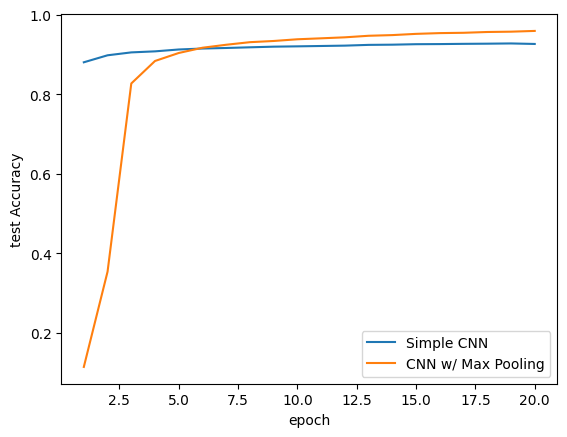

After pooling model predictions (orig, lr, ul): 0.7252191 0.7501786 0.7597856


In [ ]:
# Section 8: Train Simple (single-conv) and Pooling model and plot their test accuracy curves

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_func = nn.CrossEntropyLoss()

# Train simple model (single conv)
results_simple = train_simple_network(
    model_simple, loss_func, train_loader, test_loader,
    score_funcs={"Accuracy": __import__('sklearn.metrics').metrics.accuracy_score},
    device=device, epochs=20, lr=0.001
)

# Train pooling model (deeper + 2x MaxPool)
# We create a fresh instance to avoid parameter sharing
pool_model = model_cnn_pool  # already defined above
results_pool = train_simple_network(
    pool_model, loss_func, train_loader, test_loader,
    score_funcs={"Accuracy": __import__('sklearn.metrics').metrics.accuracy_score},
    device=device, epochs=20, lr=0.001
)

# Plot results (convert DataFrames to show same x/y)
sns.lineplot(x='epoch', y='test Accuracy', data=results_simple, label='Simple CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=results_pool, label='CNN w/ Max Pooling')
plt.xlabel('epoch'); plt.ylabel('test Accuracy'); plt.legend(); plt.show()

# Run shifted-image prediction using the trained pooling model (as in exercise)
pool_model_cpu = pool_model.cpu().eval()
p_orig_tr = pred(pool_model_cpu, img)
p_lr_tr   = pred(pool_model_cpu, img_lr)
p_ul_tr   = pred(pool_model_cpu, img_ul)
print("After pooling model predictions (orig, lr, ul):", p_orig_tr[correct_class], p_lr_tr[correct_class], p_ul_tr[correct_class])


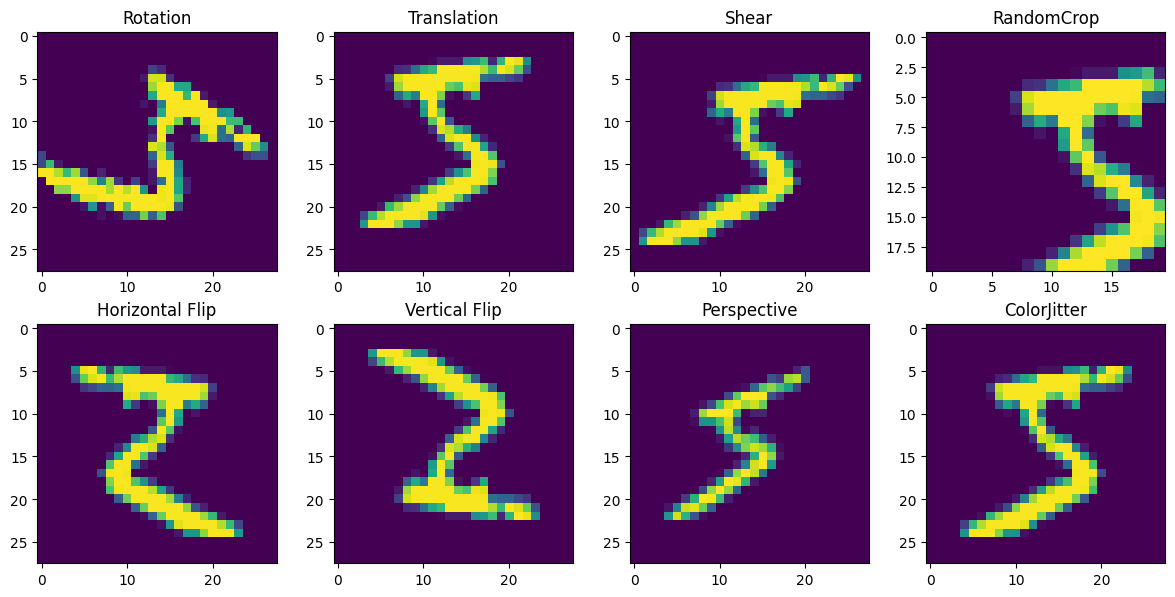

Epoch: 100%|██████████| 20/20 [06:58<00:00, 20.95s/it]


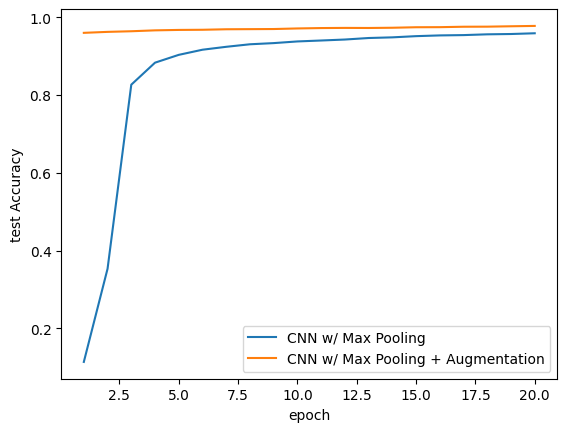

In [ ]:
# Section 9: Data augmentation pipeline, loaders, training, and plot comparison

# Display sample transforms visually
sample_transforms = {
    "Rotation": transforms.RandomAffine(degrees=45),
    "Translation": transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop": transforms.RandomCrop((20,20)),
    "Horizontal Flip": transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),
    "ColorJitter": transforms.ColorJitter(brightness=0.9, contrast=0.9)
}

pil_img = transforms.ToPILImage()(torch.tensor(img))
fig, ax = plt.subplots(2,4, figsize=(12,6))
for idx, (name, t) in enumerate(sample_transforms.items()):
    r = idx // 4; c = idx % 4
    ax[r,c].imshow(t(pil_img))
    ax[r,c].set_title(name)
plt.tight_layout(); plt.show()

# Augmentation transforms for training (as per exercise)
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05,0.05), scale=(0.98,1.02)),
    transforms.ToTensor()
])
test_transform = transforms.ToTensor()

mnist_train_aug = torchvision.datasets.MNIST('./data', train=True, transform=train_transform, download=True)
mnist_test_det  = torchvision.datasets.MNIST('./data', train=False, transform=test_transform, download=True)

train_aug_loader = DataLoader(mnist_train_aug, batch_size=B, shuffle=True, num_workers=2)
test_det_loader  = DataLoader(mnist_test_det,  batch_size=B, shuffle=False, num_workers=2)

# Recreate pooling model fresh, then train with augmented train loader
pool_model_aug = nn.Sequential(*list(model_cnn_pool.children()))  # copy architecture
results_pool_aug = train_simple_network(
    pool_model_aug, loss_func, train_aug_loader, test_det_loader,
    score_funcs={"Accuracy": __import__('sklearn.metrics').metrics.accuracy_score},
    device=device, epochs=20, lr=0.001
)

# Plot comparison: pool vs pool + augmentation
sns.lineplot(x='epoch', y='test Accuracy', data=results_pool, label='CNN w/ Max Pooling')
sns.lineplot(x='epoch', y='test Accuracy', data=results_pool_aug, label='CNN w/ Max Pooling + Augmentation')
plt.xlabel('epoch'); plt.ylabel('test Accuracy'); plt.legend(); plt.show()
